In [1]:
import sys
sys.path.append('/Users/kasperrasmussen/Documents/Github/boeva_infercnvpy/infercnvpy')

In [2]:
import infercnvpy as cnv
import scanpy as sc
import pandas as pd
from os.path import exists
import numpy as np
import anndata as anndata
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from hmmlearn import hmm
import infercnvpy as cnv
from scipy import stats

In [3]:
%load_ext autoreload
%autoreload 2

In [347]:
adata = sc.read_h5ad('/Users/kasperrasmussen/Documents/Github/kasper_cnv/data/adata/hmm_oligodendroglioma.h5ad')

In [319]:
adata

AnnData object with n_obs × n_vars = 184 × 8508
    obs: 'cell_type'
    var: 'chromosome', 'start', 'end'

In [320]:
cnv

<module 'infercnvpy' from '/Users/kasperrasmussen/Documents/GitHub/boeva_infercnvpy/infercnvpy/src/infercnvpy/__init__.py'>

In [350]:
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=["Oligodendrocytes (non-malignant)", "Microglia/Macrophage"],
    window_size=101,
    step=1,
    n_jobs=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [351]:
adata.obsm['X_cnv'].shape

(184, 8419)

In [352]:
cnv.tl.hmm_denoising(
    adata=adata,
    reference_key='cell_type',
    reference_cat=["Oligodendrocytes (non-malignant)", "Microglia/Macrophage"],
    subclone_key='cell_type',
    key_used = 'cnv',
    key_added = 'hmm_iters',
    iterations=10,
)

/Users/kasperrasmussen/Documents/GitHub/boeva_infercnvpy/infercnvpy/src/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


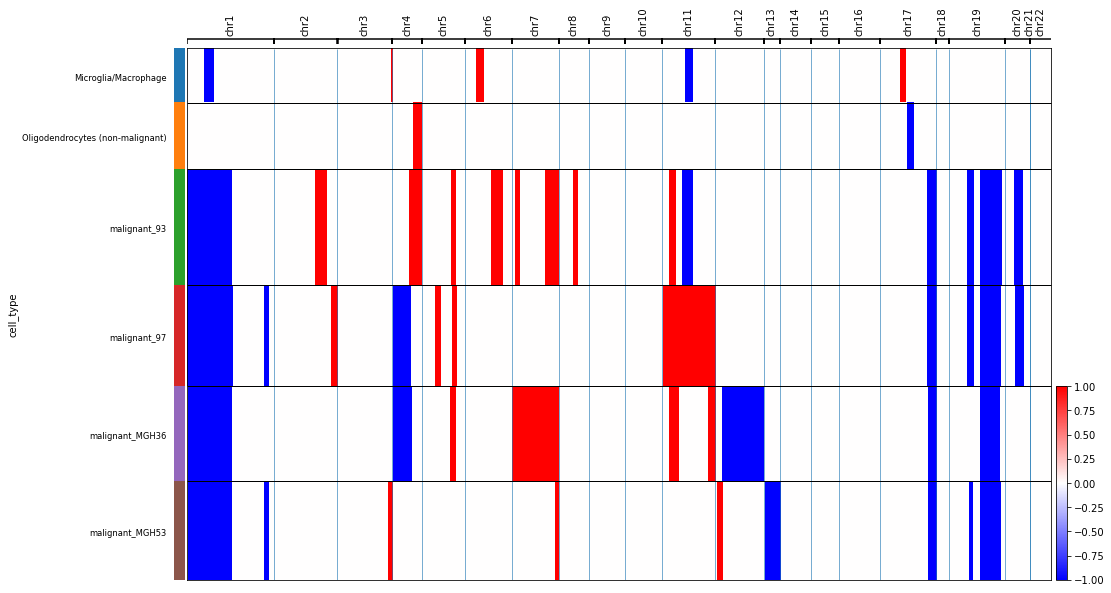

In [22]:
cnv.pl.chromosome_heatmap(adata, use_rep='hmm', groupby="cell_type")

/Users/kasperrasmussen/Documents/GitHub/boeva_infercnvpy/infercnvpy/src/infercnvpy/pl/_chromosome_heatmap.py:58: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


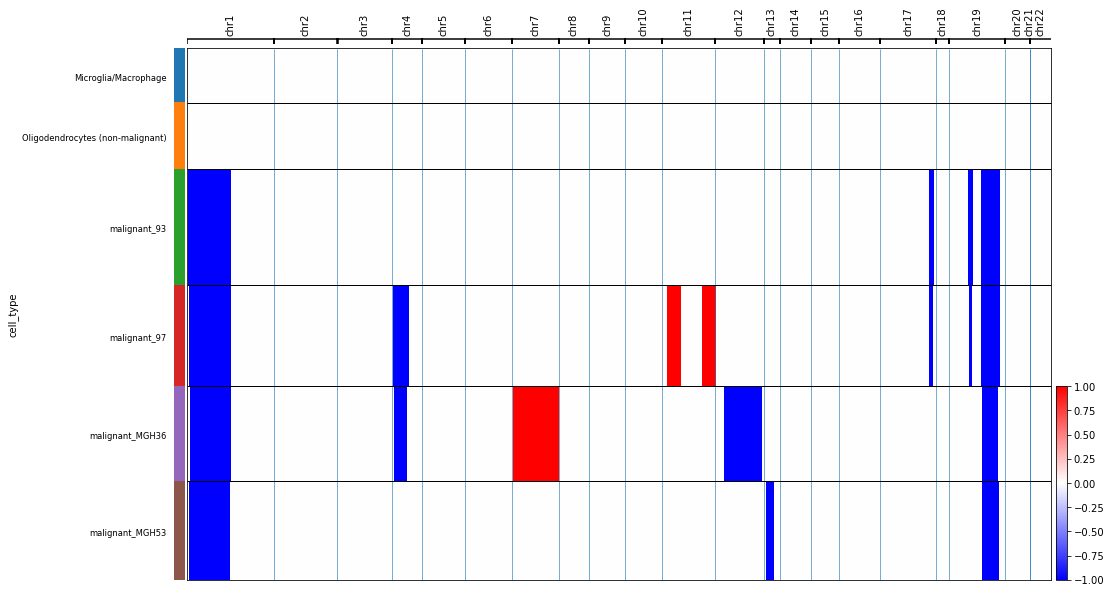

In [24]:
cnv.pl.chromosome_heatmap(adata, use_rep='hmm_iters', groupby="cell_type")

In [10]:
import umap

In [354]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

In [355]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

In [356]:
adata.obsm['X_cnv_pca'].shape

(184, 50)

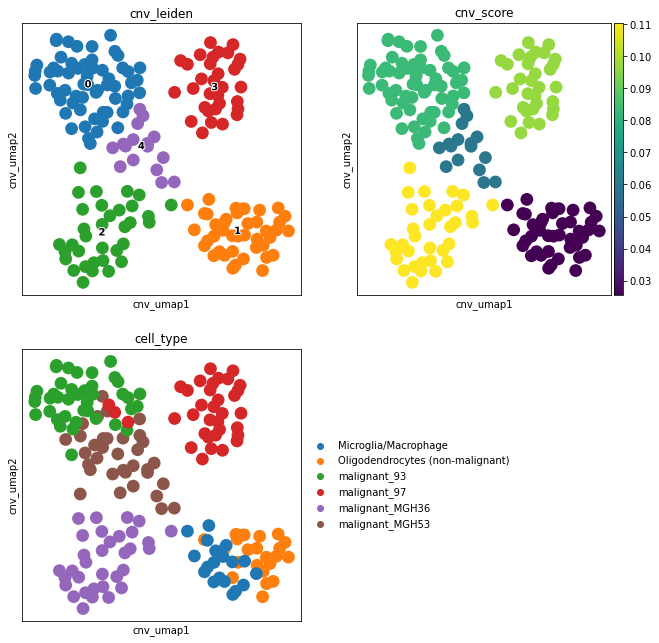

In [357]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

In [358]:

from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from sklearn import cluster, datasets, mixture

In [419]:
def get_tree_rep(model, X):
  ii = itertools.count(X.shape[0] )
  tree_rep = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]
  return tree_rep
def get_height(node_id, tree_rep):
  n_leaves = tree_rep[0]['node_id']
  if node_id < n_leaves:
    return 1
  else:
    tree_rep_index = node_id - n_leaves
    left_id = tree_rep[tree_rep_index]['left']
    right_id = tree_rep[tree_rep_index]['right']
    left_height = get_height(left_id, tree_rep)
    right_height = get_height(right_id, tree_rep)
    return max(left_height, right_height) + 1

def height_tree_rep(tree_rep):
  node_id = tree_rep[-1]['node_id']
  return get_height(node_id, tree_rep)
def get_leaves(node_id, tree_rep, X):
  n_leaves = tree_rep[0]['node_id']
  if node_id < n_leaves:
    return [node_id]
  else:
    tree_rep_index = node_id - n_leaves
    left_id = tree_rep[tree_rep_index]['left']
    right_id = tree_rep[tree_rep_index]['right']
    left_leaves = get_leaves(left_id, tree_rep, X)
    right_leaves = get_leaves(right_id, tree_rep, X)
    return left_leaves + right_leaves
def get_random_perm(matrix):
  num_cols = matrix.shape[1]
  # Generate a random permutation for each column
  permutations = [np.random.permutation(matrix[:, i]) for i in range(num_cols)]
  # Apply each permutation to the corresponding column of the matrix
  permuted_matrix = np.column_stack(permutations)
  return permuted_matrix
def score(model, X):
  return height_tree_rep(get_tree_rep(model, X))
def get_perm_scores(X, n_perms, p_val):
  p_val_idx_min = min(int(n_perms * p_val),n_perms-1)
  p_val_idx_max = min(int(n_perms * (1-p_val)),n_perms-1)
  #print('p val idx max', p_val, p_val_idx_max)
  #print('p val idx min', p_val, p_val_idx_min)
  heights = np.zeros(n_perms, dtype=np.int32)
  for i in range(n_perms):
    X_perm = get_random_perm(X)
    X_perm = ((X_perm.T - X_perm.mean(axis=1)) / X_perm.std(axis=1)).T
    model_perm = AgglomerativeClustering(linkage='ward').fit(X_perm)
    heights[i] = score(model_perm, X_perm)
    if i == 0: 
        plt.scatter(X_perm[:,0], X_perm[:,1])
        plt.title(f'perm - {i}, stat {heights[i]} n {len(X_perm)}')
        plt.show()
  heights = np.sort(heights)
  return heights, heights[p_val_idx_min], heights[p_val_idx_max]
def stop_at(i, tree_rep, X, p_val, n_perms):
  n_leaves = tree_rep[0]['node_id']
  if i < n_leaves:
    return True
  else:
    #statistic_i = get_height(i, tree_rep)
    X_i = X[get_leaves(i, tree_rep, X)]
    X_i = ((X_i.T - X_i.mean(axis=1)) / X_i.std(axis=1)).T
    model_i = AgglomerativeClustering(linkage='ward').fit(X_i)
    statistic_i = score(model_i, X_i)
    adjusted_p_val = p_val * ((len(X_i) - 1) / (len(X) - 1))
    plt.scatter(X_i[:,0], X_i[:,1])
    plt.title(f'i {i}, stat {statistic_i} n {len(X_i)}')
    plt.show()
    scores, percentile_min, percentile_max = get_perm_scores(X_i, n_perms=n_perms, p_val=p_val) #adjusted_p_val)
    print(i, scores, 'min', percentile_min, 'max', percentile_max, 'statistic', statistic_i)
    perc_a = (scores > statistic_i).sum() / len(scores)
    perc_b = (scores < statistic_i).sum() / len(scores)
    print(perc_a, perc_b)
    stop = perc_a < (1-adjusted_p_val) and perc_b < (1-adjusted_p_val) #statistic_i > percentile_min and statistic_i < percentile_max
    #stop = not not_stop
    return stop
def find_stops(i, tree_rep, X, p_val, n_perms):
  #print('fs', i)
  n_leaves = tree_rep[0]['node_id']
  if i < n_leaves:
    print('At leaf')
    return [i]
  else:
    if stop_at(i, tree_rep, X, p_val=p_val, n_perms=n_perms):
      print('Not at leaf but stopping at', i, 'with cluster size', len(get_leaves(i, tree_rep, X)))
      return [i]
    else:
      tree_rep_index = i - n_leaves
      left_id = tree_rep[tree_rep_index]['left']
      right_id = tree_rep[tree_rep_index]['right']
      print('Not stopping at ', i, 'going to children', left_id, right_id, tree_rep_index)
      return find_stops(left_id, tree_rep, X, p_val = p_val, n_perms=n_perms) + find_stops(right_id, tree_rep, X, p_val = p_val, n_perms=n_perms)
def get_labels(tree_rep, X, p_val, n_perms):
  max_id = tree_rep[-1]['node_id']
  stops = find_stops(max_id, tree_rep, X, p_val=p_val, n_perms=n_perms)
  labels = np.zeros((X.shape[0]))
  for i, stop_id in enumerate(stops):
    stop_leaf_idx = get_leaves(stop_id, tree_rep, X)
    labels[stop_leaf_idx] = i
  return labels, len(stops)

In [383]:
adata

AnnData object with n_obs × n_vars = 184 × 8508
    obs: 'cell_type', 'cnv_leiden', 'cnv_score'
    var: 'chromosome', 'start', 'end'
    uns: 'cnv', 'hmm_iters', 'cnv_neighbors', 'leiden', 'cnv_leiden_colors', 'cell_type_colors'
    obsm: 'X_cnv', 'X_hmm_iters', 'X_cnv_pca', 'X_cnv_umap'
    obsp: 'cnv_neighbors_distances', 'cnv_neighbors_connectivities'

In [396]:
X = adata.obsm['X_cnv_pca']
X = ((X.T - X.mean(axis=1)) / X.std(axis=1)).T
X.shape

In [397]:
X.shape

(184, 50)

(184, 50)

In [399]:
#X = adata.obsm['X_cnv_pca']
model0 = AgglomerativeClustering(linkage='ward').fit(X)
tree0 = get_tree_rep(model0, X)
score0 = score(model0, X)
score0

15

In [400]:
Xp = get_random_perm(X) #adata.obsm['X_cnv_pca']
modelp = AgglomerativeClustering(linkage='ward').fit(Xp)
treep = get_tree_rep(modelp, Xp)
scorep = score(modelp, Xp)
scorep

15

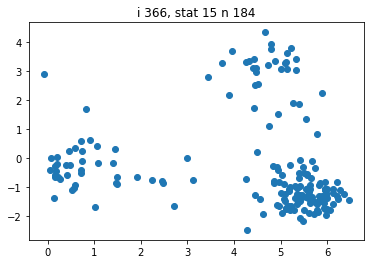

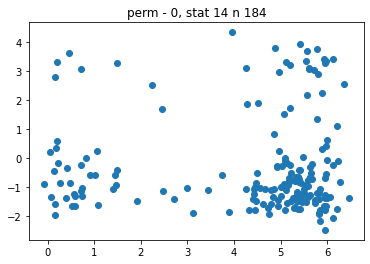

366 [12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16
 16 16 16 16 16 16 16 17] min 12 max 16 statistic 15
0.065 0.655
Not at leaf but stopping at 366 with cluster size 184


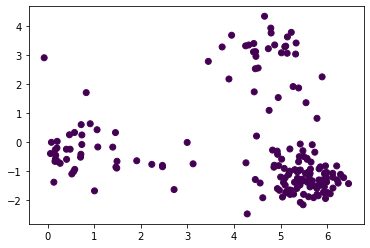

In [402]:
#n_samples = 1000
#X, y = datasets.make_blobs(n_samples=n_samples, random_state=8)
#X = adata.obsm['X_cnv_pca'] #.todense()
model0 = AgglomerativeClustering(linkage='ward').fit(X)
tree0 = get_tree_rep(model0, X)
score0 = score(model0, X)
#print(score0)
labels, _ = get_labels(tree0, X, p_val=0.01, n_perms=200)
plt.scatter(X[:,0], X[:,1], c=labels)

In [367]:
max(labels)

10.0

In [337]:
labels

array([ 5.,  0.,  1.,  1.,  1.,  5.,  1.,  1.,  5.,  6.,  5.,  1.,  5.,
        5.,  4.,  1.,  5.,  1.,  5.,  5.,  1.,  5.,  1.,  5.,  5.,  0.,
        6.,  5.,  5.,  6.,  5.,  5.,  5.,  3.,  6.,  2.,  0.,  5.,  2.,
        6.,  5.,  3.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7., 10., 10., 10.,
       10.,  9.,  9.,  9.,  9., 10., 10.,  9., 10., 10., 10., 10., 10.,
        9.,  9.,  9.,  9.,  9.,  9., 10.,  9., 10., 10., 10., 10., 10.,
        9., 10.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10.,  8., 10.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8

In [338]:
labels = np.array(labels, dtype=np.int32)
adata.obs['agg'] = labels

In [339]:
adata.obs['agg']

cell_id
MGH54_P16_F12     5
MGH54_P12_C10     0
MGH54_P11_C11     1
MGH54_P15_D06     1
MGH54_P16_A03     1
                 ..
97_P6_D09         8
97_P6_B09         8
97_P5_D01        10
97_P6_G12        10
97_P6_A06        10
Name: agg, Length: 184, dtype: int32

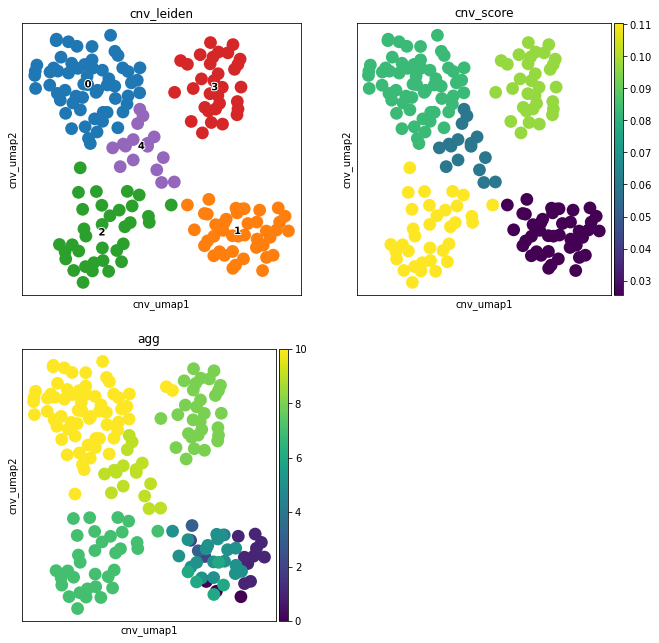

In [340]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="agg", ax=ax3)

In [403]:
adata = cnv.datasets.maynard2020_3k()
adata.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()



,ensg,chromosome,start,end
symbol,,,,
AL645933.5,ENSG00000288587.1,chr6,31400702,31463705
AC010184.1,ENSG00000288585.1,chr3,141449745,141456434
AC023296.1,ENSG00000288580.1,chr8,2923568,2926689
AL117334.2,ENSG00000288577.1,chr20,3406380,3410036
AC107294.4,ENSG00000288576.1,chr3,184778723,184780720


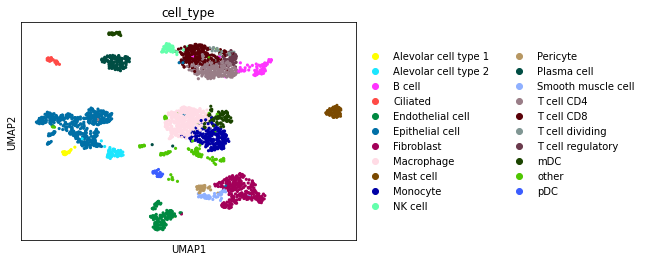

In [404]:
sc.pl.umap(adata, color="cell_type")

In [405]:
cnv.tl.infercnv(
    adata,
    reference_key="cell_type",
    reference_cat=[
        "B cell",
        "Macrophage",
        "Mast cell",
        "Monocyte",
        "NK cell",
        "Plasma cell",
        "T cell CD4",
        "T cell CD8",
        "T cell regulatory",
        "mDC",
        "pDC",
    ],
    window_size=250,
)

  0%|          | 0/1 [00:03<?, ?it/s]

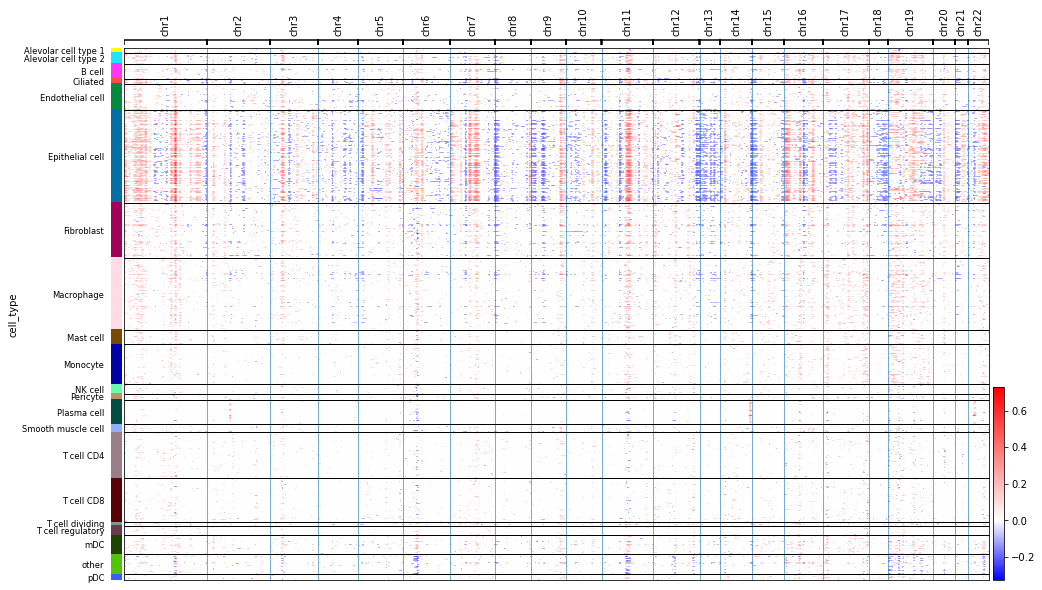

In [297]:
cnv.pl.chromosome_heatmap(adata, groupby="cell_type")

In [406]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


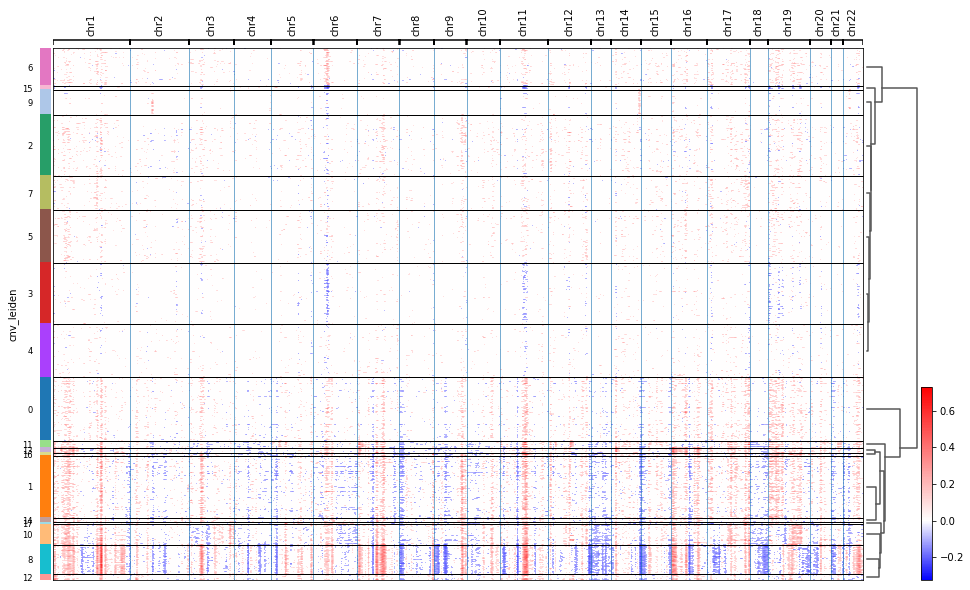

In [300]:
cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

In [407]:
cnv.tl.umap(adata)
cnv.tl.cnv_score(adata)

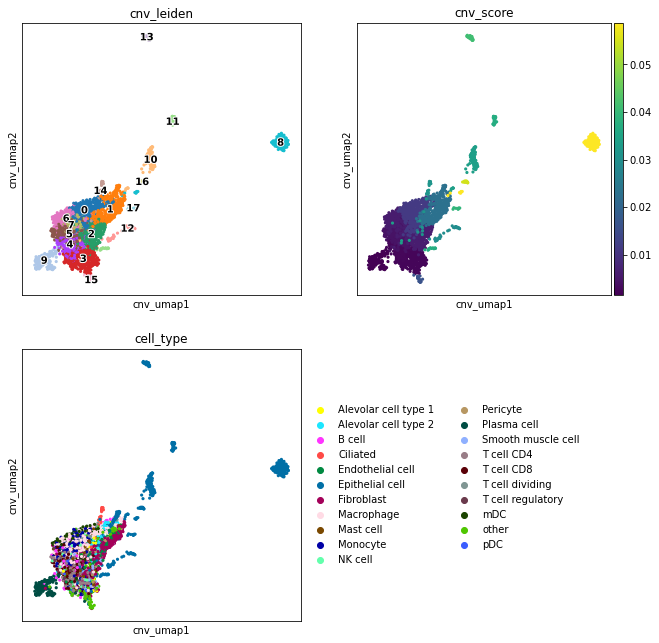

In [409]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)

cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata, color="cell_type", ax=ax3)

In [410]:
X = adata.obsm['X_cnv_pca']
X = ((X.T - X.mean(axis=1)) / X.std(axis=1)).T
X.shape

(3000, 50)

In [421]:
model0 = AgglomerativeClustering(linkage='ward', compute_distances=True).fit(X)
tree0 = get_tree_rep(model0, X)
score0 = score(model0, X)


In [422]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

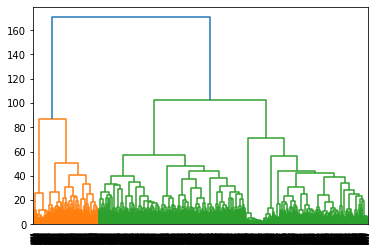

In [423]:
plot_dendrogram(model0)

In [416]:
model0.distances_.shape

(2999,)

In [417]:
model0.children_

array([[  54,  405],
       [1909, 2192],
       [1228, 2574],
       ...,
       [5966, 5992],
       [5994, 5995],
       [5996, 5997]])

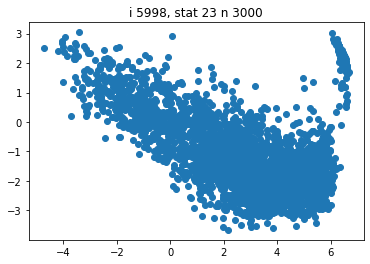

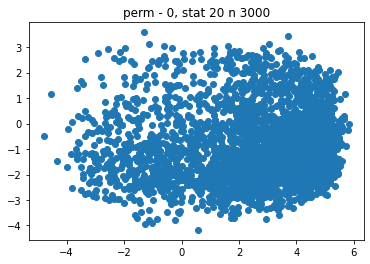

5998 [17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 21 21 21 21] min 18 max 20 statistic 23
0.0 1.0
Not stopping at  5998 going to children 5996 5997 2998


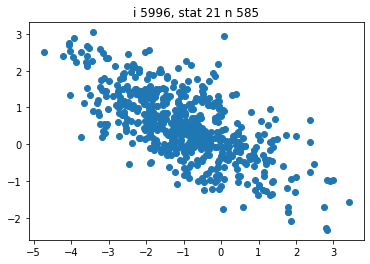

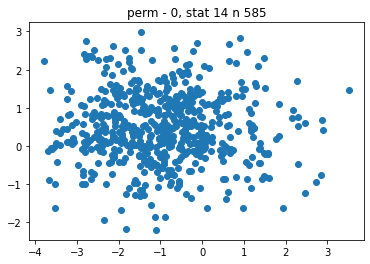

5996 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 15 15 15 16] min 13 max 15 statistic 21
0.0 1.0
Not stopping at  5996 going to children 5966 5992 2996


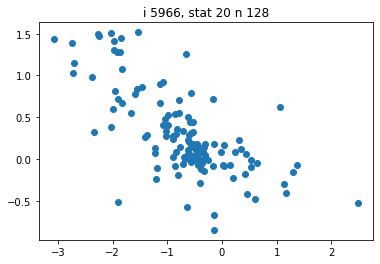

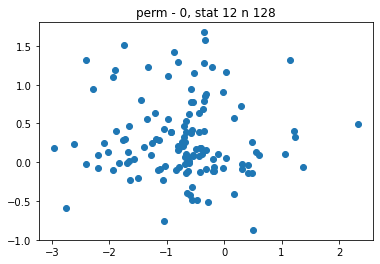

5966 [11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 14
 15 15 15 15] min 11 max 14 statistic 20
0.0 1.0
Not stopping at  5966 going to children 5781 5807 2966


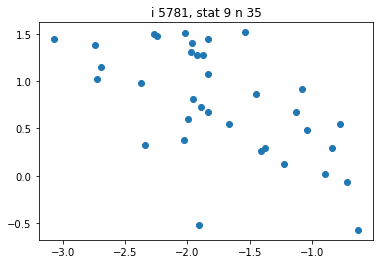

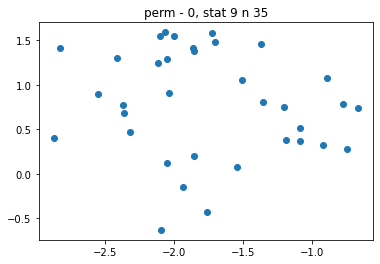

5781 [ 7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 11 12] min 8 max 10 statistic 9
0.24 0.34
Not at leaf but stopping at 5781 with cluster size 35


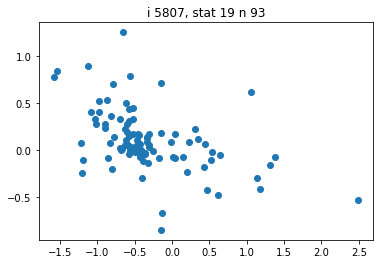

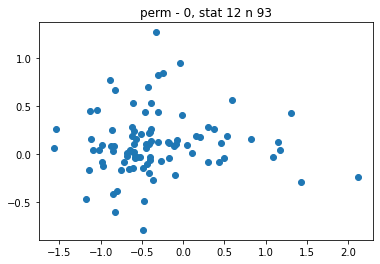

5807 [10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14
 14 15 15 16] min 11 max 14 statistic 19
0.0 1.0
Not stopping at  5807 going to children 5353 5714 2807


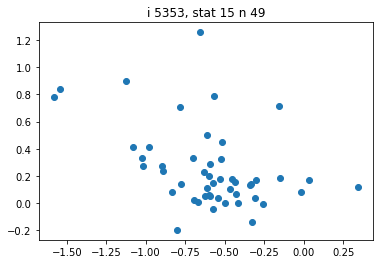

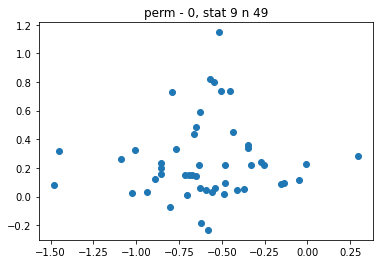

5353 [ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12
 12 12 13 13] min 9 max 12 statistic 15
0.0 1.0
Not stopping at  5353 going to children 3210 4486 2353


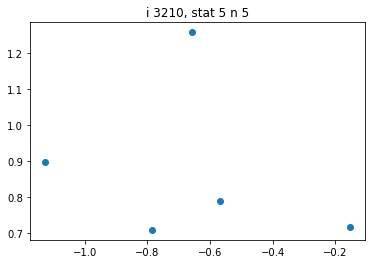

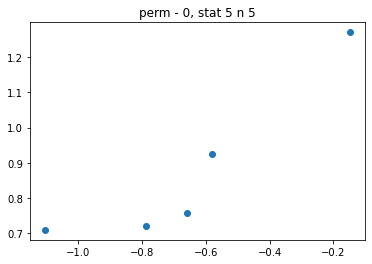

3210 [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5] min 4 max 5 statistic 5
0.0 0.6
Not at leaf but stopping at 3210 with cluster size 5


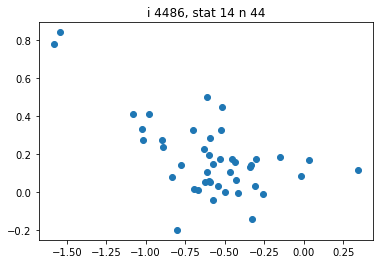

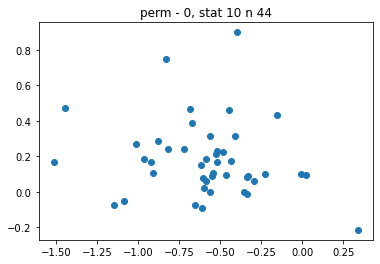

4486 [ 8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12
 12 13 13 15] min 9 max 12 statistic 14
0.01 0.99
Not at leaf but stopping at 4486 with cluster size 44


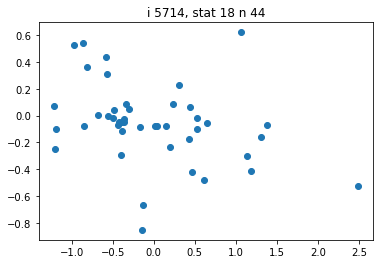

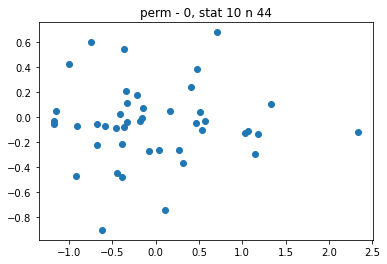

5714 [ 9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 13 13 13] min 9 max 12 statistic 18
0.0 1.0
Not stopping at  5714 going to children 5084 5354 2714


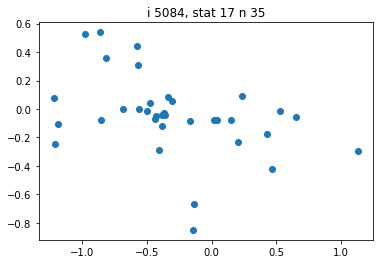

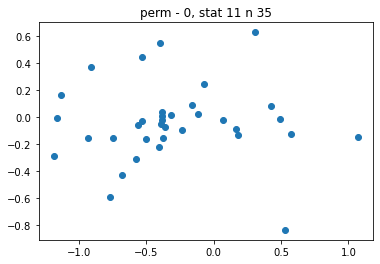

5084 [ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12
 12 12 12 13] min 9 max 12 statistic 17
0.0 1.0
Not stopping at  5084 going to children 4115 4844 2084


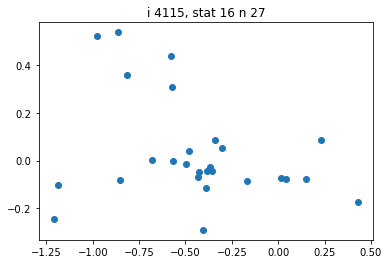

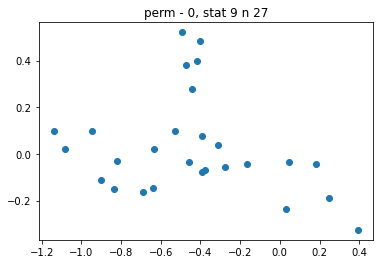

4115 [ 7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11
 11 12 13 13] min 8 max 11 statistic 16
0.0 1.0
Not stopping at  4115 going to children 3487 4062 1115


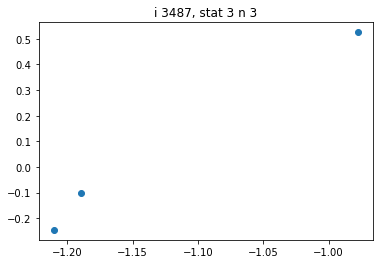

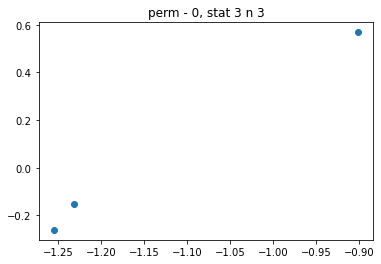

3487 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] min 3 max 3 statistic 3
0.0 0.0
Not at leaf but stopping at 3487 with cluster size 3


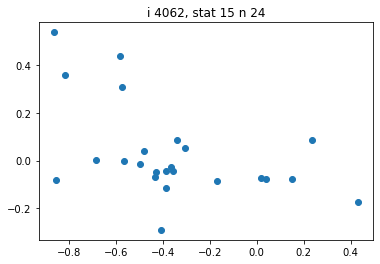

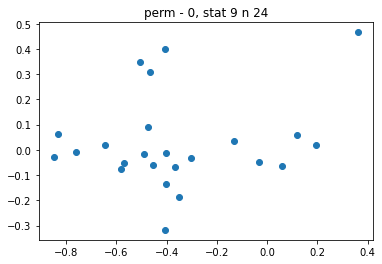

4062 [ 7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12
 12 12 12 12] min 8 max 12 statistic 15
0.0 1.0
Not stopping at  4062 going to children 3653 3812 1062


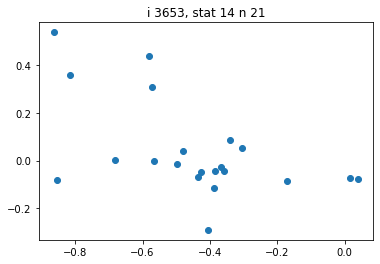

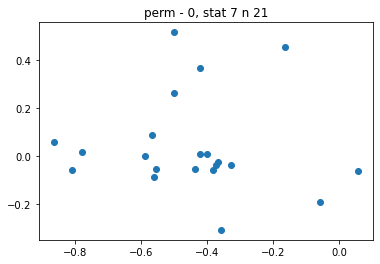

3653 [ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11
 11 11 11 12] min 7 max 11 statistic 14
0.0 1.0
Not stopping at  3653 going to children 3316 3390 653


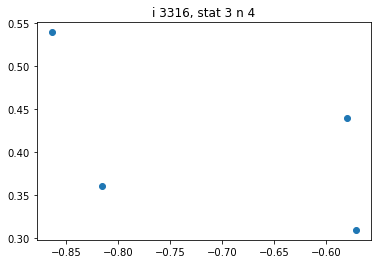

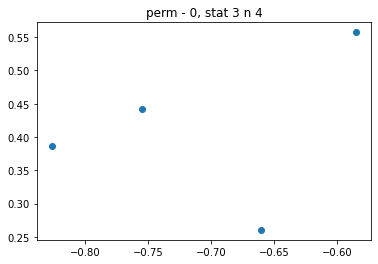

3316 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4] min 3 max 4 statistic 3
0.57 0.0
Not at leaf but stopping at 3316 with cluster size 4


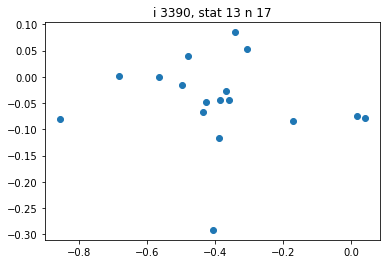

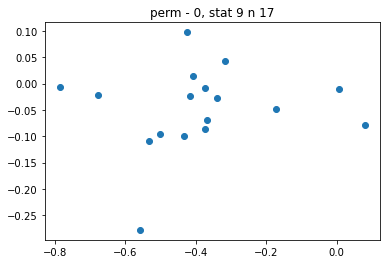

3390 [ 7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 13] min 7 max 11 statistic 13
0.0 0.99
Not at leaf but stopping at 3390 with cluster size 17


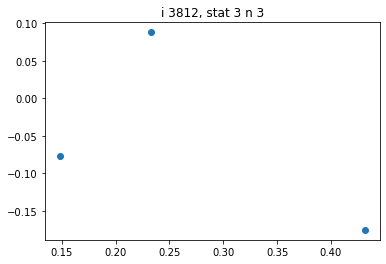

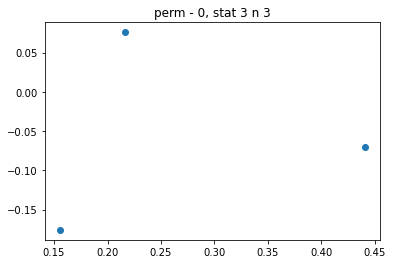

3812 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] min 3 max 3 statistic 3
0.0 0.0
Not at leaf but stopping at 3812 with cluster size 3


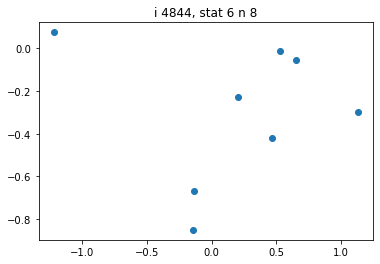

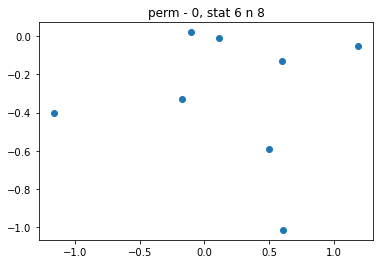

4844 [4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7] min 5 max 7 statistic 6
0.08 0.5
Not at leaf but stopping at 4844 with cluster size 8


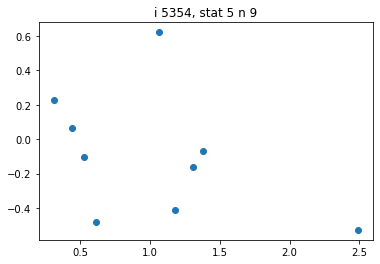

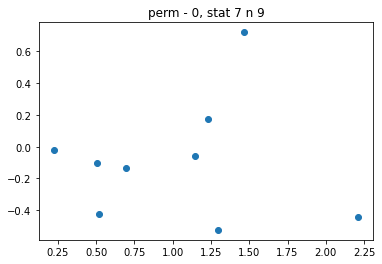

5354 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 8] min 5 max 7 statistic 5
0.65 0.0
Not at leaf but stopping at 5354 with cluster size 9


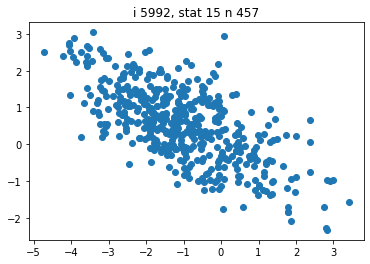

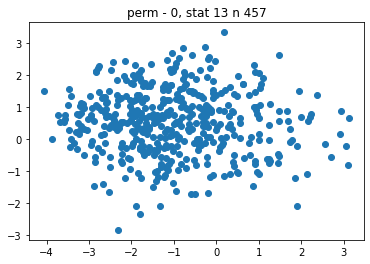

5992 [12 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15
 15 16 16 16] min 13 max 15 statistic 15
0.03 0.89
Not at leaf but stopping at 5992 with cluster size 457


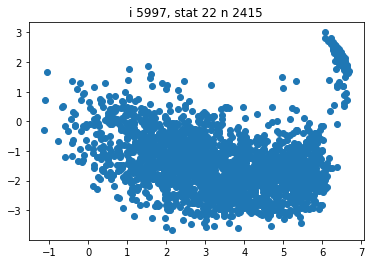

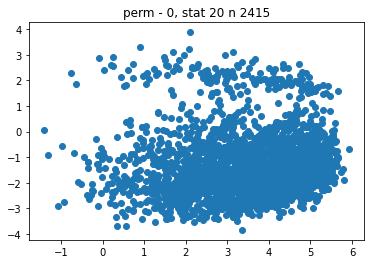

KeyboardInterrupt: 

In [420]:
#print(score0)
labels, _ = get_labels(tree0, X, p_val=0.05, n_perms=100)
plt.scatter(X[:,0], X[:,1], c=labels)

In [305]:
labels = np.array(labels, dtype=np.int32)
adata.obs['agg'] = labels

In [309]:
labels.max()

42

In [308]:
adata.obs

,age,sex,sample,patient,cell_type,cnv_leiden,cnv_score,agg
Run,,,,,,,,
SRR10796381,53,female,LT_S74,TH248,T cell CD4,3,0.002373,39
SRR10787713,40,female,LT_S75,TH266,Macrophage,0,0.011293,41
SRR10785570,56,male,LT_S28,TH185,T cell CD4,5,0.004353,4
SRR10790048,69,female,LT_S65,TH238_NAT,Monocyte,3,0.002373,38
SRR10782528,46,female,LT_S08,TH103,Epithelial cell,17,0.038929,42
...,...,...,...,...,...,...,...,...
SRR10782593,71,female,LT_S47,TH220,Fibroblast,2,0.006201,5
SRR10789971,55,male,LT_S21,TH185,Epithelial cell,8,0.058688,42
SRR10780468,62,male,LT_S58,TH179,Epithelial cell,1,0.022952,42
